## Homework 4

Use this notebook as a starter

In [3]:
import pandas as pd
import numpy as np
import wget
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

Data:

- https://github.com/gastonstat/CreditScoring
- Also available [here](https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv)

In [7]:
url = "https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv"
    
wget.download(url)

100% [............................................................................] 182489 / 182489

'CreditScoring.csv'

## Preparation 

We'll talk about this dataset in more details in week 6. But for now, use the following code to get started

In [8]:
df = pd.read_csv('CreditScoring.csv')
df.columns = df.columns.str.lower()

Some of the features are encoded as numbers. Use the following code to de-code them:

In [9]:
status_values = {
    1: 'ok',
    2: 'default',
    0: 'unk'
}

df.status = df.status.map(status_values)


home_values = {
    1: 'rent',
    2: 'owner',
    3: 'private',
    4: 'ignore',
    5: 'parents',
    6: 'other',
    0: 'unk'
}

df.home = df.home.map(home_values)

marital_values = {
    1: 'single',
    2: 'married',
    3: 'widow',
    4: 'separated',
    5: 'divorced',
    0: 'unk'
}

df.marital = df.marital.map(marital_values)

records_values = {
    1: 'no',
    2: 'yes',
    0: 'unk'
}

df.records = df.records.map(records_values)

job_values = {
    1: 'fixed',
    2: 'partime',
    3: 'freelance',
    4: 'others',
    0: 'unk'
}

df.job = df.job.map(job_values)

Prepare the numerical variables:

In [10]:
for c in ['income', 'assets', 'debt']:
    df[c] = df[c].replace(to_replace=99999999, value=0)

Remove clients with unknown default status

In [11]:
df = df[df.status != 'unk'].reset_index(drop=True)

Create the target variable

In [12]:
df['default'] = (df.status == 'default').astype(int)
del df['status']

## Your code

What are the categorical variables? What are the numerical?

In [100]:
len(df)

4454

In [101]:
df.dtypes

seniority     int64
home         object
time          int64
age           int64
marital      object
records      object
job          object
expenses      int64
income        int64
assets        int64
debt          int64
amount        int64
price         int64
default       int32
dtype: object

In [102]:
for col in df.columns:
    print (col)
    print (df[col].unique()[:7])
    print (df[col].nunique())
    print()

seniority
[ 9 17 10  0  1 29  6]
47

home
['rent' 'owner' 'parents' 'private' 'other' 'ignore' 'unk']
7

time
[60 36 12 48 18 24 54]
11

age
[30 58 46 24 26 36 44]
50

marital
['married' 'widow' 'single' 'separated' 'divorced' 'unk']
6

records
['no' 'yes']
2

job
['freelance' 'fixed' 'partime' 'unk' 'others']
5

expenses
[73 48 90 63 46 75 35]
94

income
[129 131 200 182 107 214 125]
352

assets
[    0  3000  2500  3500 10000 15000  4000]
159

debt
[   0 2500  260 2000  500 3300 3000]
182

amount
[ 800 1000 2000  900  310  650 1600]
285

price
[ 846 1658 2985 1325  910 1645 1800]
1419

default
[0 1]
2



In [24]:
df.columns

Index(['seniority', 'home', 'time', 'age', 'marital', 'records', 'job',
       'expenses', 'income', 'assets', 'debt', 'amount', 'price', 'default'],
      dtype='object')

In [90]:
numerical = ['seniority', 'time', 'age', 'expenses', 'income', 'assets', 'debt', 'amount', 'price']

categorical = ['home','marital', 'records', 'job', 'default'] 

Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use `train_test_split` funciton for that with `random_state=1`

In [103]:
from sklearn.model_selection import train_test_split

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state= 1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state= 1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train['default']
y_val = df_val['default']
y_test = df_test['default']

del df_train['default']
del df_val['default']
del df_test['default']

In [104]:
df_train.columns



Index(['seniority', 'home', 'time', 'age', 'marital', 'records', 'job',
       'expenses', 'income', 'assets', 'debt', 'amount', 'price'],
      dtype='object')

## Question 1

ROC AUC could also be used to evaluate feature importance of numerical variables. 

Let's do that

* For each numerical variable, use it as score and compute AUC with the "default" variable
* Use the training dataset for that


If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['expenses']`)

AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

In [93]:
from sklearn.metrics import roc_auc_score

for num in numerical:
    print(num,round (roc_auc_score(y_train, -df_train[num]),3))

seniority 0.709
time 0.439
age 0.573
expenses 0.501
income 0.682
assets 0.649
debt 0.505
amount 0.409
price 0.496


In [94]:
for num in numerical:
    print(num,round (roc_auc_score(y_train, df_train[num]),3))

seniority 0.291
time 0.561
age 0.427
expenses 0.499
income 0.318
assets 0.351
debt 0.495
amount 0.591
price 0.504


Which numerical variable (among the following 4) has the highest AUC?

- seniority
- time
- income
- debt

## Training the model

From now on, use these columns only:

```
['seniority', 'income', 'assets', 'records', 'job', 'home']
```

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

In [147]:
model_col = ['seniority', 'income', 'assets', 'records', 'job', 'home']

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

dv= DictVectorizer(sparse= False)

train_dicts = df_train[model_col].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)



In [192]:
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

model.fit(X_train, y_train)



LogisticRegression(max_iter=1000, solver='liblinear')

In [193]:
val_dicts = df_val[model_col].to_dict(orient='records')


In [194]:
X_val = dv.transform(val_dicts)

y_pred = model.predict_proba(X_val)[:,1]


In [195]:
round (roc_auc_score(y_val, y_pred),3)

0.812

## Question 2

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.512
- 0.612
- 0.712
- 0.812

## Question 3

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

In [196]:
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

thresholds = np.linspace(0, 1, 101)
scores = []
for t in thresholds:
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    scores.append((t, tp, fp, fn, tn))
    

In [201]:
columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns=columns)

df_scores['precision'] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores['recall'] = df_scores.tp / (df_scores.tp + df_scores.fn)



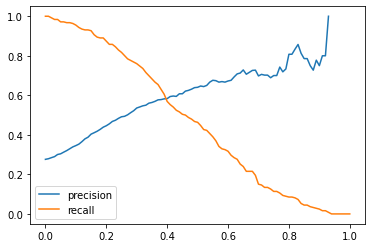

In [202]:
plt.plot(df_scores.threshold, df_scores['precision'], label='precision')
plt.plot(df_scores.threshold, df_scores['recall'], label='recall')
plt.legend()

At which threshold precision and recall curves intersect?

* 0.2
* 0.4
* 0.6
* 0.8

## Question 4

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

In [212]:
df_scores["f1_score"] = 2*(((df_scores['precision'])*(df_scores['recall']))/(df_scores['recall']+ df_scores['precision']))

df_scores.sort_values(['f1_score'], ascending = False)

,threshold,tp,fp,fn,tn,precision,recall,f1_score
30,0.30,187,162,59,483,0.535817,0.760163,0.628571
31,0.31,184,156,62,489,0.541176,0.747967,0.627986
32,0.32,181,150,65,495,0.546828,0.735772,0.627383
34,0.34,172,135,74,510,0.560261,0.699187,0.622061
33,0.33,176,144,70,501,0.550000,0.715447,0.621908
...,...,...,...,...,...,...,...,...
96,0.96,0,0,246,645,NaN,0.000000,NaN
97,0.97,0,0,246,645,NaN,0.000000,NaN
98,0.98,0,0,246,645,NaN,0.000000,NaN
99,0.99,0,0,246,645,NaN,0.000000,NaN


At which threshold F1 is maximal?

- 0.1
- 0.3
- 0.5
- 0.7

## Question 5


Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation


In [213]:
!pip install tqdm

In [231]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[model_col].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear',C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [232]:
def predict(df, dv, model):
    dicts = df[model_col].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [233]:
from tqdm.auto import tqdm
from sklearn.model_selection import KFold

In [252]:
n_splits = 5


kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

scores = []

for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.default.values
        y_val = df_val.default.values

        dv, model = train(df_train, y_train, C=1)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)
print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

C=10 0.814 +- 0.015


In [253]:
dv, model = train(df_full_train, df_full_train.default.values, C=1.0)
y_pred = predict(df_test, dv, model)

auc = roc_auc_score(y_test, y_pred)
auc

0.775937855707055

How large is standard devidation of the scores across different folds?

- 0.001
- 0.014
- 0.09
- 0.14

## Question 6

Now let's use 5-Fold cross-validation to find the best parameter C

* Iterate over the following C values: `[0.01, 0.1, 1, 10]`
* Use these parametes for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std

In [251]:

n_splits = 5
for C in tqdm([0.01, 0.1, 1, 10]):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.default.values
        y_val = df_val.default.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    #print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))
    print(f"for C={C} \t mean:{np.mean(scores):.3f}\t standard Deviation:{np.std(scores):.3f}")

  0%|          | 0/4 [00:00<?, ?it/s]

for C=0.01 	 mean:0.808	 standard Deviation:0.012
for C=0.1 	 mean:0.813	 standard Deviation:0.014
for C=1 	 mean:0.814	 standard Deviation:0.015
for C=10 	 mean:0.814	 standard Deviation:0.015


Which C leads to the best mean score?

- 0.01
- 0.1
- 1
- 10

If you have ties, select the score with the lowest std. If you still have ties, select the smallest C

## Submit the results

Submit your results here: https://forms.gle/e497sR5iB36mM9Cs5

It's possible that your answers won't match exactly. If it's the case, select the closest one.

## Deadline

The deadline for submitting is 04 October 2021, 17:00 CET. After that, the form will be closed.